# Plotting for tutorial

In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
from utilities import sample_rkhs_func_from_kernels, get_posterior_from_data, aposteriori_scaling
import sklearn
from sklearn.gaussian_process.kernels import RBF
import os

In [3]:
np.random.seed(123456)

Ground truth

In [4]:
n_eval = 1000
xs = np.linspace(-10, 10, n_eval).reshape([-1,1])
kernel_true = RBF(length_scale=0.8)
rkhs_norm_true = 2
ys = sample_rkhs_func_from_kernels(xs, rkhs_norm_true, 50, kernel_true).flatten()

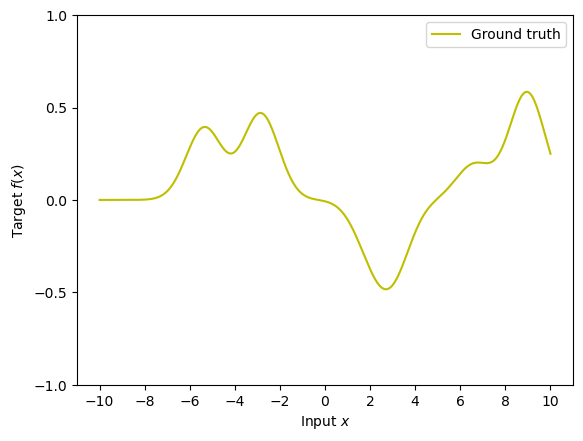

In [5]:
plt.plot(xs, ys, '-y')
plt.xlabel('Input $x$')
plt.ylabel('Target $f(x)$')
plt.legend(['Ground truth'])
plt.yticks(np.arange(-1,1.5,0.5))
_ = plt.xticks(np.arange(-10,12,2))
plt.savefig('figures/tutorial_1.pdf', dpi=200)

Data set

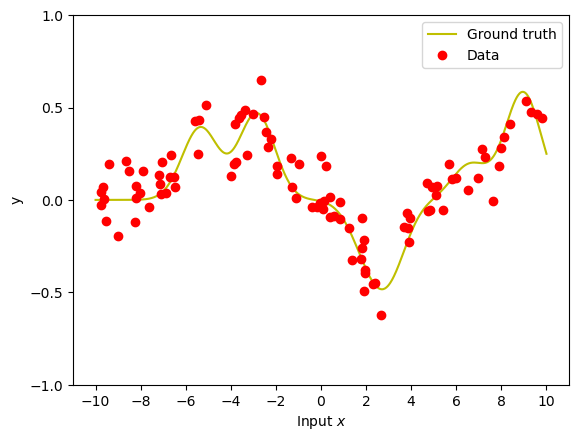

In [6]:
n_samples = 100
noise_level = 0.1
ind_train = np.random.choice(np.arange(n_eval), n_samples, replace=False)
xs_train = xs[ind_train]
ys_train = ys[ind_train] + np.random.normal(loc=0, scale=noise_level, size=n_samples)
plt.plot(xs, ys, 'y')
plt.plot(xs_train, ys_train, 'ro')
plt.xlabel('Input $x$')
plt.ylabel('y')
plt.legend(['Ground truth', 'Data'])
plt.yticks(np.arange(-1,1.5,0.5))
_ = plt.xticks(np.arange(-10,12,2))
plt.savefig('figures/tutorial_2.pdf', dpi=200)

Run GPR and determine beta

In [7]:
kernel = kernel_true

# Build Kernel matrix
K = kernel(xs_train.reshape([-1,1]), xs_train.reshape([-1,1]))

#Inverse kernel matrix times training outputs (used for posterior mean)
KinvY = la.solve(K + noise_level*np.identity(n_samples), ys_train)

# Posterior mean evaluated at test_inputs
post_mean = kernel(xs,xs_train) @ KinvY

# Post variance evaluated at test_inputs
post_covar = kernel.diag(xs)[:,None] - kernel(xs, xs_train) @ la.inv(K + noise_level*np.identity(n_samples)) @ kernel(xs_train, xs)
post_var = np.diag(post_covar)

delta = 0.01
rkhs_norm_beta = 3
beta = aposteriori_scaling(K, rkhs_norm_beta, noise_level, 1, delta)

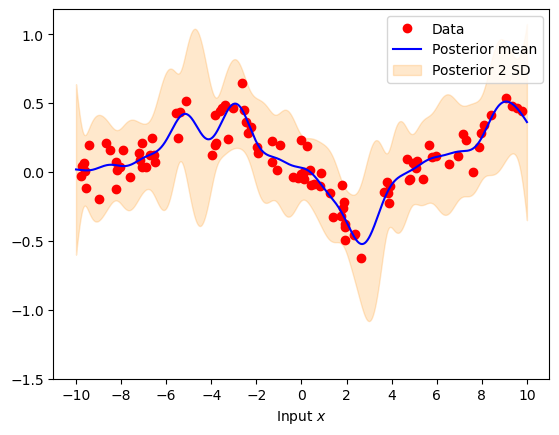

In [8]:
#plt.plot(xs, ys, '-y')
plt.plot(xs_train, ys_train, 'ro')
plt.plot(xs, post_mean, 'b')
plt.fill_between(xs.flatten(), post_mean + 2*np.sqrt(post_var), post_mean - 2*np.sqrt(post_var),
                color='darkorange', alpha=0.2)
plt.xlabel('Input $x$')
plt.yticks(np.arange(-1.5,1.5,0.5))
plt.legend(['Data', 'Posterior mean', 'Posterior 2 SD'])
_ = plt.xticks(np.arange(-10,12,2))
plt.savefig('figures/tutorial_3.pdf', dpi=200)

Plot everything

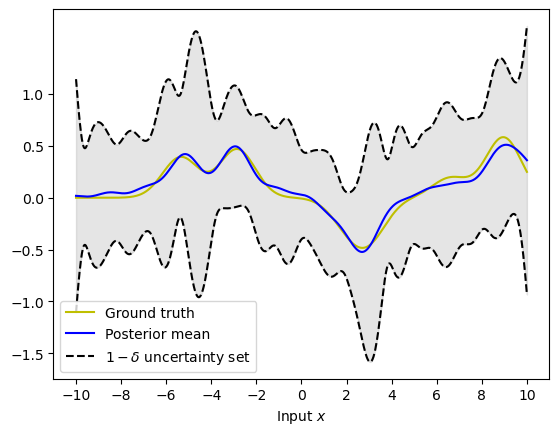

In [9]:
plt.plot(xs, ys, '-y')
#plt.plot(xs_train, ys_train, 'ro')
plt.plot(xs, post_mean, 'b')
plt.fill_between(xs.flatten(), post_mean + beta*np.sqrt(post_var), post_mean - beta*np.sqrt(post_var),
                color='gray', alpha=0.2)
plt.plot(xs, post_mean + beta*np.sqrt(post_var), 'k--')
plt.plot(xs, post_mean - beta*np.sqrt(post_var), 'k--')
plt.xlabel('Input $x$')
plt.legend(['Ground truth', 'Posterior mean', '$1-\delta$ uncertainty set'])
plt.yticks(np.arange(-1.5,1.5,0.5))
_ = plt.xticks(np.arange(-10,12,2))
plt.savefig('figures/tutorial_4.pdf', dpi=200)